<a href="https://colab.research.google.com/github/Md-Ferdous/M.Sc-Kuet/blob/master/protein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
import numpy as np
from time import time
from tensorflow.keras import optimizers, callbacks
from timeit import default_timer as timer
 
import pickle
from sklearn.model_selection import train_test_split
import sys
 
 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, TimeDistributed,  BatchNormalization, Flatten
 
from tensorflow.keras.regularizers import l2
 
import tensorflow as tf
 

dataset_path = "/content/drive/My Drive/cullpdb+profile_6133_filtered.npy"
    

sequence_len = 700
total_features = 57
amino_acid_residues = 21
num_classes = 8
cnn_width = 17
 
def get_dataset(path):
    ds = np.load(path)      # dataset has 6133 protein and 39990 features
    ds = np.reshape(ds, (ds.shape[0], sequence_len, total_features)) # reshaped into 6133 protein, 700 amino acids, 57 features
    ret = np.zeros((ds.shape[0], ds.shape[1], amino_acid_residues + num_classes)) # create tmp set of 6133,700,30
    ret[:, :, 0:amino_acid_residues] = ds[:, :, 35:56]   # assign 21 amino acids
    ret[:, :, amino_acid_residues:] = ds[:, :, amino_acid_residues + 1:amino_acid_residues+ 1 + num_classes] # assign 8 classes
    return ret
 
def get_data_labels(D):
    X = D[:, :, 0:amino_acid_residues]  
    Y = D[:, :, amino_acid_residues:amino_acid_residues + num_classes]
    return X, Y
 
def resphape_labels(labels):
    Y = np.reshape(labels, (labels.shape[0]*labels.shape[1], labels.shape[2]))
    Y = Y[~np.all(Y == 0, axis=1)]    # eliminate rows whose all values are 0
    return Y
 
def reshape_data(X):
    padding = np.zeros((X.shape[0], X.shape[2], int(cnn_width/2))) 
    X = np.dstack((padding, np.swapaxes(X, 1, 2), padding))  #Stack arrays in sequence depth wise (along third axis).
    X = np.swapaxes(X, 1, 2)
    res = np.zeros((X.shape[0], X.shape[1] - cnn_width + 1, cnn_width, amino_acid_residues))
    for i in range(X.shape[1] - cnn_width + 1):   # 716 - 17 +1 = 700 
        res[:, i, :, :] = X[:, i:i+cnn_width, :]
    res = np.reshape(res, (X.shape[0]*(X.shape[1] - cnn_width + 1), cnn_width, amino_acid_residues))
    res = res[np.count_nonzero(res, axis=(1,2))>(int(cnn_width/2)*amino_acid_residues), :, :]  # eliminate some rows whose nonzero element is less than 168
    return res
 
def get_dataset_reshaped(seed=None):
    D = get_dataset(dataset_path)
    Train, Test, Validation = split_dataset(D,seed)
    X_te, Y_te = get_data_labels(Test)
    X_tr, Y_tr = get_data_labels(Train)
    X_v, Y_v = get_data_labels(Validation)
 
    X_train = reshape_data(X_tr)
    X_test = reshape_data(X_te)
    X_validation = reshape_data(X_v)
 
    Y_train = resphape_labels(Y_tr)
    Y_test = resphape_labels(Y_te)
    Y_validation = resphape_labels(Y_v)
 
    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test
 
def split_dataset(Dataset,seed=None): 
    np.random.seed(seed)
    np.random.shuffle(Dataset)
    train_split = int(Dataset.shape[0]*0.8) # 80% for training
    test_val_split = int(Dataset.shape[0]*0.1) # 10% for testing and validation
    Train = Dataset[0:train_split, :, :]
    Test = Dataset[train_split:train_split+test_val_split, :, :]
    Validation = Dataset[train_split+test_val_split:, :, :]
    return Train, Test, Validation
 
 
do_log = True
stop_early = False
show_plots = True
 
start_time = timer()
 
print("Collecting Dataset...")
 

X_train, X_val, X_test, Y_train, Y_val, Y_test = get_dataset_reshaped(seed=100)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

 
end_time = timer()
print("\n\nTime elapsed getting Dataset: " + "{0:.2f}".format((end_time - start_time)) + " s")
 

print("Using CullPDB Filtered dataset")
 


(947263, 17, 21)
(947263, 8)
(114941, 17, 21)
(114941, 8)
(121114, 17, 21)
(121114, 8)


Time elapsed getting Dataset: 18.44 s
Using CullPDB Filtered dataset


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 17, 128)           13568     
_________________________________________________________________
batch_normalization_3 (Batch (None, 17, 128)           512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 17, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 17, 128)           49280     
_________________________________________________________________
batch_normalization_4 (Batch (None, 17, 128)           512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 17, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 17, 64)           

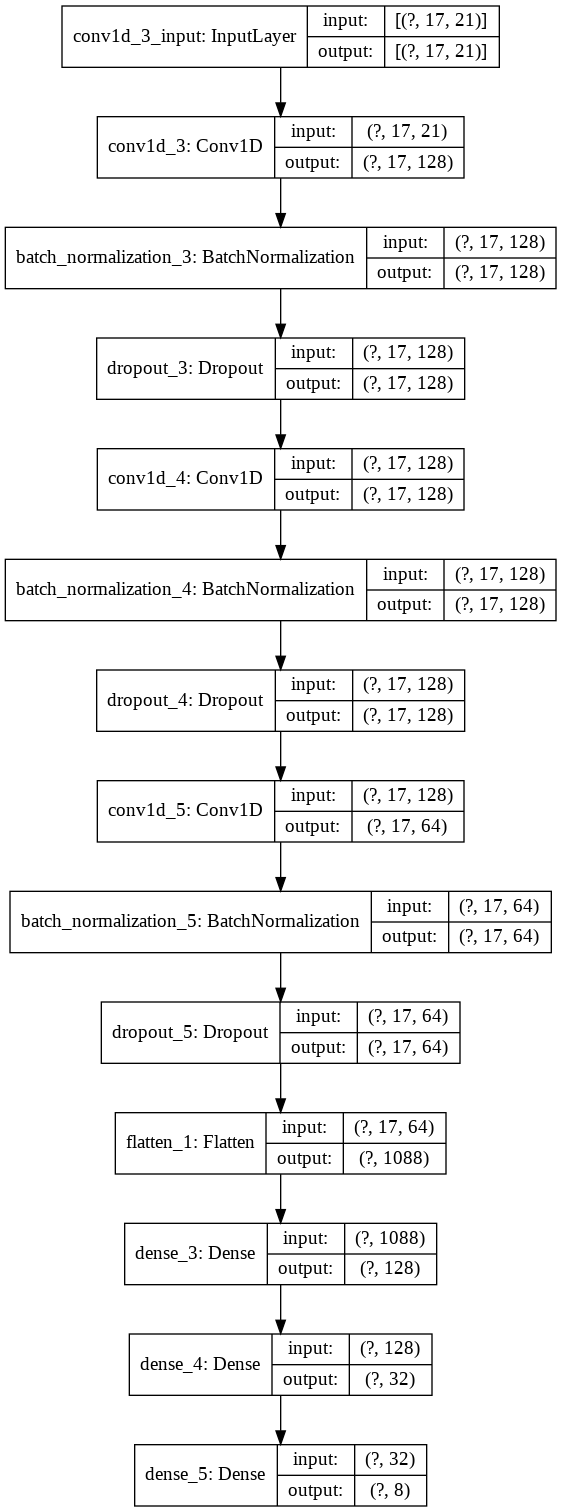

In [11]:
 
LR = 0.0009 
drop_out = 0.38
batch_dim = 64
nn_epochs = 35
 

loss = 'categorical_crossentropy' 
#loss = 'mean_absolute_error' 
#loss = 'mean_squared_logarithmic_error'
 

def CNN_model():
    m = Sequential()
    m.add(Conv1D(128, 5, padding='same', activation='relu', input_shape=(cnn_width, amino_acid_residues)))
    m.add(BatchNormalization())
   
    m.add(Dropout(drop_out))
    m.add(Conv1D(128, 3, padding='same', activation='relu'))
    m.add(BatchNormalization())
   
    m.add(Dropout(drop_out))
    m.add(Conv1D(64, 3, padding='same', activation='relu'))
    m.add(BatchNormalization())
    
    m.add(Dropout(drop_out))
    
    m.add(Flatten())
    m.add(Dense(128, activation='relu'))
    m.add(Dense(32, activation='relu'))
    m.add(Dense(num_classes, activation = 'softmax'))
    opt = optimizers.Adam(lr=LR)
    m.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy', 'mae'])
    
    return m
 
 
 
net = CNN_model()
print(net.summary())
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(net, to_file=dot_img_file, show_shapes=True)

In [12]:
history = net.fit(X_train, Y_train, epochs=nn_epochs, batch_size=batch_dim, shuffle=True,
                        validation_data=(X_val, Y_val))
scores = net.evaluate(X_test, Y_test)
print("Loss: " + str(scores[0]) + ", Accuracy: " + str(scores[1]) + ", MAE: " + str(scores[2]))

Epoch 1/35
14801/14801 [==============================] - 71s 5ms/step - loss: 0.9339 - accuracy: 0.6634 - mae: 0.1103 - val_loss: 0.8606 - val_accuracy: 0.6857 - val_mae: 0.1051
Epoch 2/35
14801/14801 [==============================] - 71s 5ms/step - loss: 0.8703 - accuracy: 0.6853 - mae: 0.1039 - val_loss: 0.8408 - val_accuracy: 0.6942 - val_mae: 0.1004
Epoch 3/35
14801/14801 [==============================] - 71s 5ms/step - loss: 0.8511 - accuracy: 0.6924 - mae: 0.1018 - val_loss: 0.8222 - val_accuracy: 0.7003 - val_mae: 0.1008
Epoch 4/35
14801/14801 [==============================] - 71s 5ms/step - loss: 0.8401 - accuracy: 0.6961 - mae: 0.1007 - val_loss: 0.8152 - val_accuracy: 0.7034 - val_mae: 0.0977
Epoch 5/35
14801/14801 [==============================] - 72s 5ms/step - loss: 0.8324 - accuracy: 0.6988 - mae: 0.1000 - val_loss: 0.8159 - val_accuracy: 0.7036 - val_mae: 0.0965
Epoch 6/35
14801/14801 [==============================] - 71s 5ms/step - loss: 0.8266 - accuracy: 0.7006 

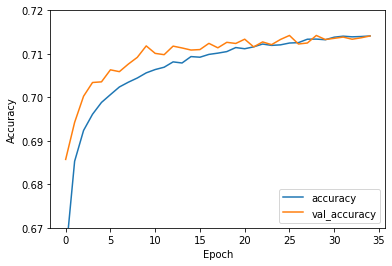

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.67, 0.72])
plt.legend(loc='lower right')

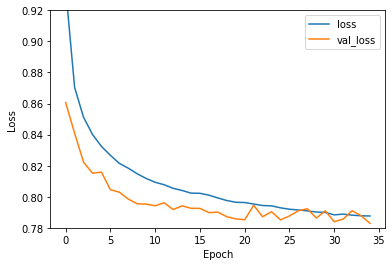

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.78, 0.92])
plt.legend(loc='upper right')

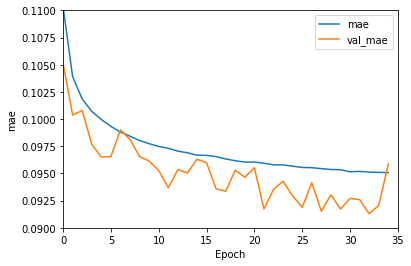

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.xlim([0,35])
plt.ylim([0.09, 0.11])
plt.legend(loc='upper right')

In [8]:
y_pred = net.predict(X_test[:])  
print(y_pred) 

[[1.0000000e+00 4.2544790e-13 4.6615667e-09 ... 2.3924684e-08
  1.9506469e-12 1.5052155e-14]
 [4.3801647e-01 3.8040399e-03 1.1027307e-02 ... 4.8212752e-01
  2.1892689e-05 5.3270672e-02]
 [1.2267115e-01 5.7111904e-03 2.4862532e-02 ... 5.6786859e-01
  5.1001113e-02 9.6428357e-02]
 ...
 [5.8819669e-01 3.6448058e-02 9.2405066e-02 ... 6.8281512e-03
  2.0221500e-01 6.0309146e-02]
 [8.4106606e-01 3.5187636e-02 5.3753305e-02 ... 9.2134513e-03
  2.8646927e-04 4.3980725e-02]
 [9.9998951e-01 3.5994809e-22 1.0450510e-05 ... 1.2850645e-09
  4.3339568e-08 4.4146803e-10]]


In [9]:
Y_test[:]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])